##IMPORTS

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

##CSV TRATAMENTS

In [1]:
#LEITURA
dataFrame = pd.read_csv("alcool.csv") #Le o dataFrame

#TRATAMENTOS
dataFrame = dataFrame.rename(columns={"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)": "alcohol consumption",
                                      "Year":"year"})

dataFrame = dataFrame.reindex(columns=['year', 'alcohol consumption']) #Reindex da coluna dos anos e valores 


avgAlcoholConsumption = dataFrame["alcohol consumption"].mean()
dataFrame['alcohol consumption'] = dataFrame['alcohol consumption'].fillna(avgAlcoholConsumption)


#SOMA DE CONSUMO
dataFrame = dataFrame.groupby(["year"])['alcohol consumption'].sum().reset_index() #Agrupa os valores por ano
dataFrame = dataFrame.set_index("year") #define o ano como index


dataFrame

NameError: ignored

##VISUAL CHARTS

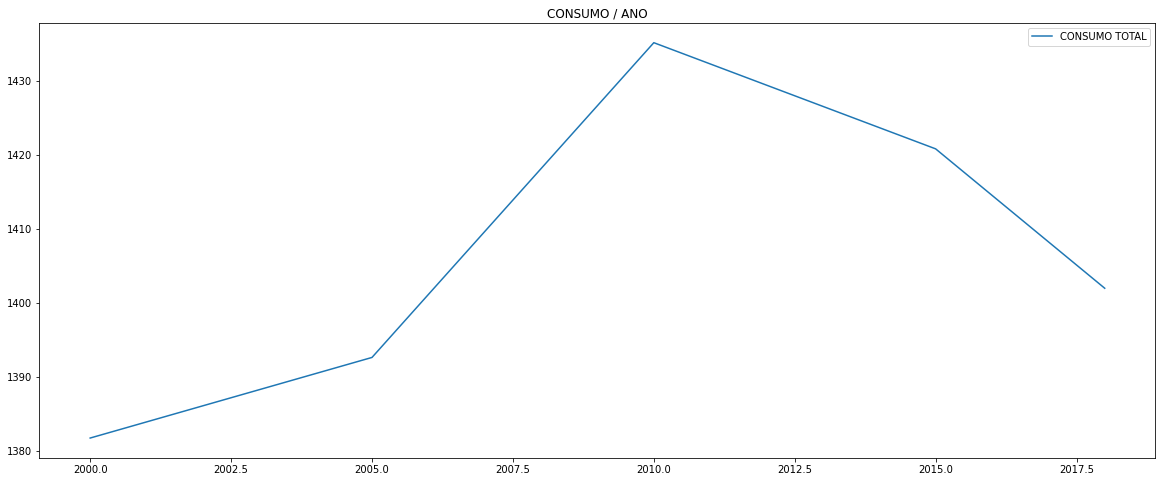

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(dataFrame.index, dataFrame.values, label='CONSUMO TOTAL');
ax.legend();
ax.set_title("CONSUMO / ANO");

##DESCRIPTION

In [ ]:
dataFrame.describe()

,alcohol consumption
count,5.000000
mean,1406.434500
std,21.529701
min,1381.696455
25%,1392.592461
50%,1401.947239
75%,1420.791626
max,1435.144720


##OUTLIERS

In [ ]:
q1 = dataFrame["alcohol consumption"].quantile(0.25)
q3 = dataFrame["alcohol consumption"].quantile(0.75)
iqr = q3-q1 #Interquartile range
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
dataFrame = dataFrame.loc[(dataFrame["alcohol consumption"] > fence_low) & (dataFrame["alcohol consumption"] < fence_high)]

In [ ]:
dataFrame.describe()

,alcohol consumption
count,5.000000
mean,1406.434500
std,21.529701
min,1381.696455
25%,1392.592461
50%,1401.947239
75%,1420.791626
max,1435.144720


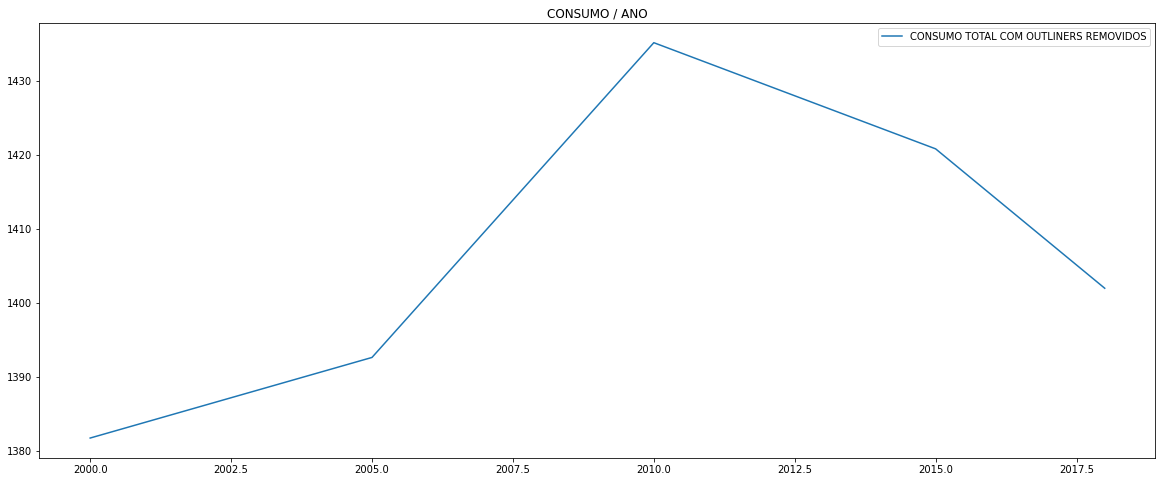

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(dataFrame.index, dataFrame.values, label='CONSUMO TOTAL COM OUTLINERS REMOVIDOS');
ax.legend();
ax.set_title("CONSUMO / ANO");

##NORMALIZE TESTS - NOT WORKING


In [ ]:
#KSTEST
stats.kstest(dataFrame['alcohol consumption'],'norm')

statistic, pvalue = stats.kstest(dataFrame['alcohol consumption'],'norm')

if pvalue > 0.29407:
  print("KSTEST - Distribuição Normal")
else: 
  print("KSTEST - Não é uma distribuição Normal")


KSTEST - Não é uma distribuição Normal


In [ ]:
#SHAPIRO
if stats.shapiro(dataFrame['alcohol consumption'])[1] > 0.05:
    print("Distribuição Normal")
else:
    print("Não é uma distribuição Normal")

Distribuição Normal


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [ ]:
#BOXCOX
dataFrameNormalized = dataFrame
dataFrameNormalized['alcohol consumption'], lambda_boxcox = stats.boxcox(dataFrame['alcohol consumption'])
dataFrameNormalized

ValueError: ignored

In [ ]:
#KSTEST
stats.kstest(dataFrame['alcohol consumption'],'norm')

statistic, pvalue = stats.kstest(dataFrame['alcohol consumption'],'norm')

if pvalue > 0.29407:
  print("KSTEST - Distribuição Normal")
else: 
  print("KSTEST - Não é uma distribuição Normal")


KSTEST - Não é uma distribuição Normal


In [ ]:
#SHAPIRO
if stats.shapiro(dataFrame['alcohol consumption'])[1] > 0.05:
    print("Distribuição Normal")
else:
    print("Não é uma distribuição Normal")

Distribuição Normal


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


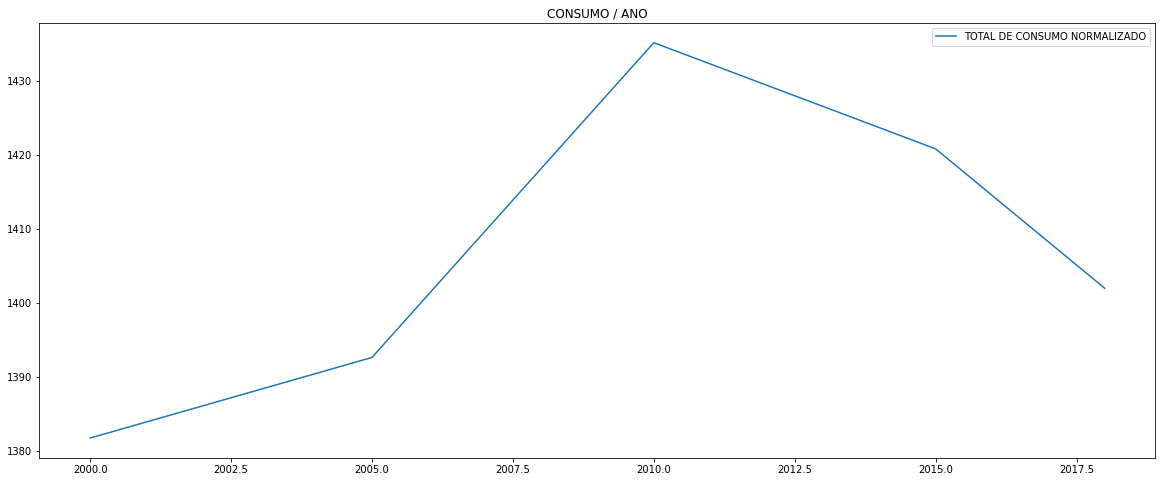

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(dataFrame.index, dataFrame.values, label='TOTAL DE CONSUMO NORMALIZADO');
ax.legend();
ax.set_title("CONSUMO / ANO");

##ARIMA

In [ ]:
rowCount = len(dataFrame.index)
size = round(rowCount*0.2)
size

1

In [ ]:
dataFrameArima = dataFrameNormalized

X = dataFrameArima.values
size = int(len(X) * 0.8)
dataFrameAnimaPrev = dataFrameArima[size:]
dataFrameAnimaPrev['quantity'] = dataFrameAnimaPrev['alcohol consumption']
training, test = X[0:size],X[size:]
history = [x for x in training]
for i in range(len(test+2)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    observation = test[i]
    history.append(observation)
    dataFrameAnimaPrev['quantity'][-len(test)+i-1:-len(test)+i] = yhat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._set_values(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.lau

In [ ]:
error = math.sqrt(mean_squared_error(test, dataFrameAnimaPrev['quantity'].values))
print('Erro médio quadratico: ', error)

Erro médio quadratico:  0.0


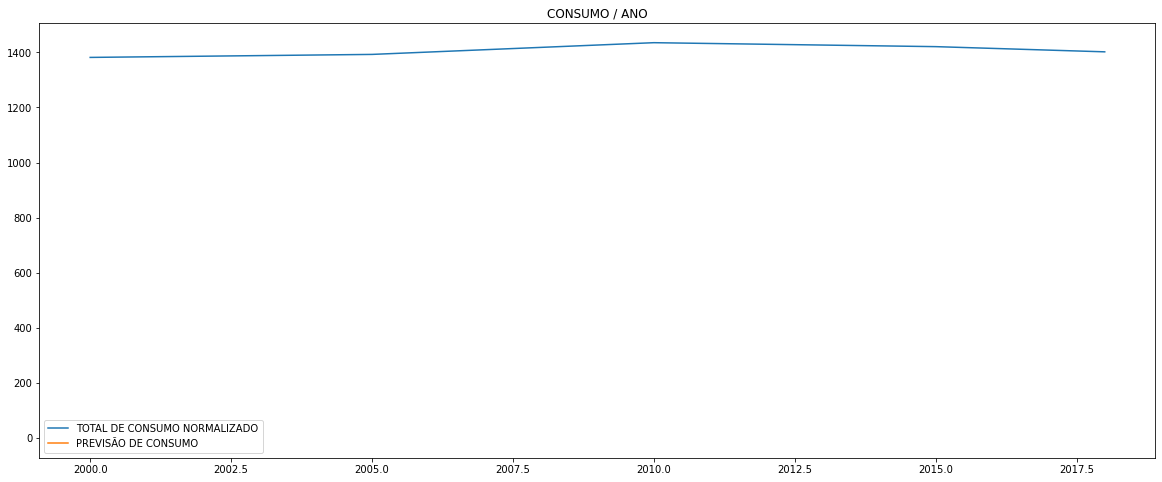

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(dataFrame.index, dataFrame['alcohol consumption'].values, label='TOTAL DE CONSUMO NORMALIZADO');
ax.plot(dataFrameAnimaPrev.index, dataFrameAnimaPrev['quantity'].values, label='PREVISÃO DE CONSUMO');
ax.legend();
ax.set_title("CONSUMO / ANO");